In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

2023-02-11 11:56:26.027071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 11:56:26.375159: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-11 11:56:28.875974: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/comp

### Import and Preprocess the Data

In [2]:
df = pd.read_json('./data/route_data.json')
df = df[df.MoonBoardHoldSetup == 'MoonBoard Masters 2017']

In [3]:
for i in range(12, 15):
    df = df[df.Grade != i]

In [4]:
undersample_5 = df[df.Grade == 5].sample(n=4250)
df = df[df.Grade != 5]
oversample_4 = df[df.Grade == 4].sample(frac=1.5, replace=True)
oversample_7 = df[df.Grade == 7].sample(frac=1.5, replace=True)
oversample_6 = df[df.Grade == 6].sample(frac=1.15, replace=True)
oversample_9 = df[df.Grade == 9].sample(frac=1.6, replace=True)
oversample_8 = df[df.Grade == 8].sample(frac=1.3, replace=True)
df = df[df.Grade != 8]
df = df[df.Grade != 6]
df = df[df.Grade != 9]
df = df[df.Grade != 4]
df = df[df.Grade != 7]
df = pd.concat([oversample_4, oversample_7, oversample_6, oversample_9, oversample_8, undersample_5, df])

<AxesSubplot:xlabel='Grade', ylabel='count'>

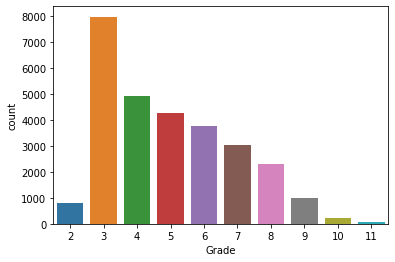

In [5]:
sns.countplot(x='Grade', data=df)

### Formatting Input

In [6]:
def get_x_y(hold: dict):
    x = ord(hold['Position'][0]) - 64
    y = int(hold['Position'][1:])
    return x, y

def get_closest_hold(current_hold: dict, valid_holds: list) -> dict:
    x1, y1 = get_x_y(current_hold)
    distances = list(map(lambda hold: ((x1 - get_x_y(hold)[0])**2 + (y1 - get_x_y(hold)[1])**2)**0.5, valid_holds))
    return valid_holds[np.argmin(distances)]

def get_next_hold(current_hold: dict, holds: list) -> dict:
    x, y = get_x_y(current_hold)
    min_y = 19
    for hold in holds:
        x2, y2 = get_x_y(hold)
        if y2 <= min_y and y2 >= y:
            min_y = y2
    valid_holds = [hold for hold in holds if get_x_y(hold)[1] == min_y]
    return get_closest_hold(current_hold, valid_holds)

In [7]:
def sort_hand_holds(moves: list, sorted_holds = []) -> list:
    holds = moves.copy()

    if len(sorted_holds) == 0:
        sorted_holds = [hold for hold in holds if hold['IsStart']]
        holds = [hold for hold in holds if hold['IsStart'] == False]

    if sorted_holds[-1]['IsEnd']:
        return list(map(lambda x: x['Position'], sorted_holds))
    
    next_hold = get_next_hold(sorted_holds[-1], holds)
    sorted_holds.append(next_hold)
    holds.remove(next_hold)

    return sort_hand_holds(holds, sorted_holds)

In [8]:
def format_input(route) -> list:
    climbing_methods = {
        'Feet follow hands': 'FFH',
        'Feet follow hands + screw ons': 'FFHSO',
        'Footless + kickboard': 'FLKB',
        'Screw ons only': 'SOO'
    }
    
    config = route.MoonboardConfiguration[:3]
    method = climbing_methods[route.Method]
    sorted_holds = sort_hand_holds(route.Moves)
    
    return [config, method] + sorted_holds

In [9]:
inputs = [format_input(route) for _, route in df.iterrows()]

In [10]:
hold_to_idx = {
    '[PAD]': 0, 
    '[START]': 1, 
    '[END]': 2
}
vocab_size = len(hold_to_idx)

def tokenize_holds(holds):
    def hold_to_idx_emplace(hold):
        global vocab_size
        if hold not in hold_to_idx:
            hold_to_idx[hold] = vocab_size
            vocab_size += 1
        return hold_to_idx[hold]
    
    return list(map(hold_to_idx_emplace, holds))

In [11]:
tokenized_inputs = [tokenize_holds(x) for x in inputs]

In [12]:
idx_to_hold = {v: k for k, v in hold_to_idx.items()}

Pad route inputs to be the same length.

In [13]:
max_len = 0
for h in tokenized_inputs:
    max_len = max(max_len, len(h))
max_len += 2 # PADDING for eventual START and END tokens during training

for i in range(len(tokenized_inputs)):
    l = len(tokenized_inputs[i])
    tokenized_inputs[i] += [0]*(max_len-l)

Tokenized input example:

In [14]:
print(tokenized_inputs[0])

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [15]:
print([idx_to_hold[i] for i in tokenized_inputs[0]])

['40°', 'FFH', 'E4', 'H3', 'I8', 'H10', 'F13', 'C13', 'F16', 'D18', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


### Train Test Split

In [16]:
X = np.array(tokenized_inputs)
y = df.Grade.to_numpy()-2

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

### Model Definition

In [18]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [19]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [20]:
embed_holds = PositionalEmbedding(vocab_size=vocab_size, d_model=512)

emb = embed_holds(X[:100])

2023-02-11 11:56:41.001149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 11:56:42.128764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13635 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:61:00.0, compute capability: 7.5


In [21]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [22]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(emb.shape)
print(sample_gsa(emb).shape)

(100, 20, 512)


2023-02-11 11:56:46.501707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


(100, 20, 512)


In [23]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [24]:
sample_ffn = FeedForward(512, 2048)

print(emb.shape)
print(sample_ffn(emb).shape)

(100, 20, 512)
(100, 20, 512)


In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [26]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(emb.shape)
print(sample_encoder_layer(emb).shape)

(100, 20, 512)
(100, 20, 512)


In [27]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [28]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocab_size)

sample_encoder_output = sample_encoder(X[:100], training=False)

# Print the shape.
print(X[:100].shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(100, 20)
(100, 20, 512)


In [29]:
class EncoderClassifier(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, num_classes, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, \
                               vocab_size=vocab_size, dropout_rate=dropout_rate)
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.final_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.encoder(x)
        x = self.seq(x)
        logits = self.final_layer(x[:, 0, :])

        try:
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### Model Training

In [31]:
num_layers = 4
d_model = 128
dff = 1024
num_heads = 8
dropout_rate = 0.3
epochs = 250
num_classes = df.Grade.nunique()

In [32]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [33]:
model = EncoderClassifier(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    vocab_size=vocab_size,
    num_classes=num_classes,
    dropout_rate=dropout_rate
)

In [34]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'])

In [35]:
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.1)

Epoch 1/250


2023-02-11 11:56:52.303222: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x48f70590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-11 11:56:52.303264: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-02-11 11:56:52.327037: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-11 11:56:52.698557: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


716/716 [==============================] - 30s 28ms/step - loss: 1.7589 - accuracy: 0.3138 - val_loss: 1.4525 - val_accuracy: 0.3844
Epoch 2/250
716/716 [==============================] - 15s 20ms/step - loss: 1.4731 - accuracy: 0.3859 - val_loss: 1.4314 - val_accuracy: 0.3970
Epoch 3/250
716/716 [==============================] - 14s 20ms/step - loss: 1.4469 - accuracy: 0.3974 - val_loss: 1.3767 - val_accuracy: 0.4127
Epoch 4/250
539/716 [=====================>........] - ETA: 3s - loss: 1.4423 - accuracy: 0.4033

KeyboardInterrupt: 

### Training Plots

In [ ]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

In [ ]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

### Model Evaluation

In [36]:
pred = model.predict(X_test)

89/89 [==============================] - 2s 11ms/step


In [37]:
cm = confusion_matrix(y_test, np.argmax(pred, axis=1))
normalized_cm = np.array([cm[i] / np.sum(cm[i]) for i in range(len(cm))])

In [38]:
accuracy = cm.diagonal().sum() / cm.sum()
top_1_accuracy = (cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum()) / cm.sum()
print('accuracy', accuracy)
print('+-1 accuracy', top_1_accuracy)

accuracy 0.42058719490626106
+-1 accuracy 0.8096922532720198


Heatmap

<AxesSubplot:>

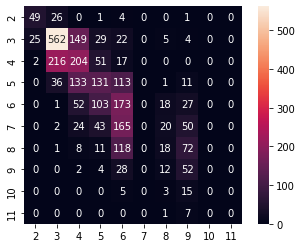

In [39]:
sns.heatmap(cm, xticklabels=range(2, 12), yticklabels=range(2, 12), annot=True, fmt='g', square=True)

Normalized Heatmap

<AxesSubplot:>

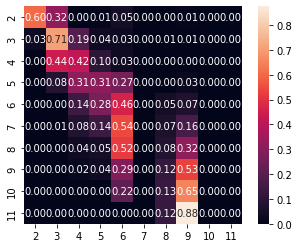

In [40]:
sns.heatmap(normalized_cm, xticklabels=range(2, 12), yticklabels=range(2, 12), annot=True, fmt='.2f', square=True)